In [1]:
# All dependencies
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import requests
import pandas as pd
import sys
import matplotlib.pyplot as plt
from copy import deepcopy
from multiprocessing import Process, Queue, Event
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as tts, cross_validate, GridSearchCV as GSCV, KFold as KF
from sklearn.preprocessing import StandardScaler as SS
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from os import path
from time import time
from mpl_toolkits.mplot3d import Axes3D as plt3

**Commonly Used Methods**

The methods below are commonly used when running a variety of classification and regression models.

**Culling the Accidents Data**

In the `accidents.csv` file, we found that there was too much data accidents of severity 2 and three recorded, leading to nearly unreadable graphs and an unusually high accuracy.  As a result, a method was created to ensure the number of all accidents was roughly even across all severities.

In [2]:
def plot_ftrs(X, y, dimensions=2, cmap="viridis"):
    components = PCA(n_components=(dimensions)).fit(X).transform(X)
    if dimensions == 2:
        fig = plt.figure().add_subplot(111)
        scatter = fig.scatter(components[:, 0], components[:, 1], c=y, cmap=cmap)
    else:
        fig = plt.figure().add_subplot(111, projection="3d")
        scatter = fig.scatter(components[:, 0], components[:, 1], components[:, 2], c=y, cmap=cmap)
    
    plt.colorbar(scatter, ax=fig, ticks=list(np.unique(y)))
    plt.show()

def dataframe_from_csv(file_name, exclude_cols):
    cols = list(pd.read_csv(f"{file_name}.csv", nrows=1))

    return pd.read_csv(f"{file_name}.csv", usecols=[a for a in cols if a not in exclude_cols])

def get_accuracy(y_test, y_pred, use_np_mean=False):
    if use_np_mean:
        accuracy = np.mean(y_test == y_pred)
    else:
        accuracy = np.dot(y_test, y_pred) / (la.norm(y_test) * la.norm(y_pred))
    
    return float(f"{accuracy * 100:.3f}")

def cull_data(dataset, features, percent_of_even_data_to_use=1):
    accident_data = data_frames[dataset][features].dropna().values
    np.random.shuffle(accident_data)
    
    unique_labels, unique_label_counts = np.unique(accident_data[:, -1], return_counts = True)
    returning_accident_data = accident_data[accident_data[:, -1] == unique_labels[0]][:int(np.min(unique_label_counts) * percent_of_even_data_to_use), :]
    for l in range(1, len(unique_labels)):
        returning_accident_data = np.vstack((returning_accident_data, accident_data[accident_data[:, -1] == unique_labels[l]][:int(np.min(unique_label_counts) * percent_of_even_data_to_use), :]))
    
    np.random.shuffle(returning_accident_data)
    return returning_accident_data

def mult_list(val_list):
    product = len(val_list[0])

    for val in val_list:
        product *= len(val_list)

    return product

def count_iters(params):
    param_lens = [len(val) for _, val in params.items()]
    return sum(param_lens) + mult_list(param_lens)
    

def custom_cv(estimator, X, y, params, test_size=0.3, timed=True, verbose=False, multiprocessed=None):
    fit_time = None
    if timed: start_time = time()

    X_train, X_test, y_train, y_test = tts(X, y, test_size=test_size)

    pipe = Pipeline([("scaler", SS()), ("gscv", GSCV(estimator, params, verbose=1 if verbose else 0))])
    pipe.fit(X_train, y_train)
    
    if timed: fit_time = time() - start_time
    if verbose and timed: print(f"Total Cross Validation fit time: {fit_time / 60:.3f} minutes")

    ret_dict = {
        "best_accuracy": get_accuracy(y_test, pipe.predict(X_test)),
        "best_params": pipe.named_steps["gscv"].best_params_,
        "best_score": pipe.named_steps["gscv"].best_score_
    }
    
    if multiprocessed is None:
        return ret_dict
    else:
        multiprocessed.put(ret_dict)
        return

def recursive_param_builder(sub_params, params_list, inter_param=None):
    if inter_param is None: inter_param = {}

    if len(sub_params.keys()) == 0: params_list.append(deepcopy(inter_param))
    else:
        next_key = list(sub_params.keys())[0]
        for val in sub_params[next_key]:
            inter_param[next_key] = [val]
            recursive_param_builder({key: value for key, value in sub_params.items() if key != next_key}, params_list, inter_param)

def check_terminate(output_queue, stop_event):
    while not stop_event.is_set():
        try:
            terminate = input("Multiprocessing GSCV, send input to terminate: ", timeout=1)
            output_queue.put(True)
            return
        except TimeoutError:
            continue
    
def manual_checkpointed_cv(estimator, X, y, params, test_size=0.3, timed=True, verbose=False):
    params_list = []
    recursive_param_builder(params, params_list)

    termination_queue = Queue()
    ret_queue = Queue()
    stop_event = Event()

    termination_process = Process(target=check_terminate, args=(termination_queue, stop_event))
    termination_process.start()

    for a in range(0, len(params_list), 2):
        p1 = Process(target=custom_cv, args=(estimator, X, y, params_list[a], test_size, timed, verbose, ret_queue))
        p2 = Process(target=custom_cv, args=(estimator, X, y, params_list[a + 1], test_size, timed, verbose, ret_queue))

        p1.start()
        p2.start()

    
    

In [3]:
params = {
    "kernel": ["linear", "rbf"],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "gamma": [0.001, 0.01, 0.1, 1, 10],
}

test_params = {
    "kernel": ["linear", "rbf"],
    "C": [0.1, 1],
    "gamma": [0.1, 1]
}

params_list = []
recursive_param_builder(test_params, params_list)
print(params_list)

[{'kernel': ['linear'], 'C': [0.1], 'gamma': [0.1]}, {'kernel': ['linear'], 'C': [0.1], 'gamma': [1]}, {'kernel': ['linear'], 'C': [1], 'gamma': [0.1]}, {'kernel': ['linear'], 'C': [1], 'gamma': [1]}, {'kernel': ['rbf'], 'C': [0.1], 'gamma': [0.1]}, {'kernel': ['rbf'], 'C': [0.1], 'gamma': [1]}, {'kernel': ['rbf'], 'C': [1], 'gamma': [0.1]}, {'kernel': ['rbf'], 'C': [1], 'gamma': [1]}]


**Downloading of the Data Files**

We used dropbox to store the CSV files and used their urls to load them into pandas Dataframes using our custom method `dataframe_from_csv`.
To save load time, if the method first checks if the datasets are already downloading before attempting to download from the dropbox.

In [4]:
# Download data files
urls = {
    "vehicles": "https://www.dropbox.com/scl/fi/rfywugpl0vxo5mc5b7uy7/Vehicles0514.csv?rlkey=v4yygd6hc96ejfm9nt1fvadz9&dl=0",
    "casualties": "https://www.dropbox.com/scl/fi/o1ljw70bzrwmx0x8etifq/Casualties0514.csv?rlkey=iwyg1ergtazhl6mgwqk78xn5s&dl=0",
    "accidents": "https://www.dropbox.com/scl/fi/7enn6tyaavc8ch8hlib0f/Accidents0514.csv?rlkey=u316i9rln87722m1fefzfp5ba&dl=0",
    "data-guide": "https://www.dropbox.com/scl/fi/amogx0ugusmivneq6ardz/Road-Accident-Safety-Data-Guide.xls?rlkey=rnkxrf6eqjer67x2lv99tzvvv&dl=0"
}

data_frames = {}

# pd.read_excel(urls["data-guide"], sheet_name="Export Variables", engine="xlrd")

exclude_columns = ["Accident_Index", "LSOA_of_Accident_Location"]
for file_name in list(urls.keys())[:-1]:
    print(f"Loading {file_name}.csv")
    if path.exists(f"{file_name}.csv"):
        data_frames[file_name] = dataframe_from_csv(file_name, exclude_columns)
        continue
        
    direct_url = urls[file_name].replace("&dl=0", "&dl=1")
    response = requests.get(direct_url)

    with open(f"{file_name}.csv", "wb") as f:
        f.write(response.content)
        print(f"Wrote {file_name}.csv")

    data_frames[file_name] = dataframe_from_csv(file_name, exclude_columns)

print("Done!")

Loading vehicles.csv
Loading casualties.csv
Loading accidents.csv
Done!


In [5]:
# First Question: How does the weather impact the serverity of the accident?
accident_data = cull_data(
    "accidents",
    ["Weather_Conditions", "Road_Surface_Conditions", "Special_Conditions_at_Site", "Carriageway_Hazards", "Accident_Severity"], 
    0.02
)

X = accident_data[:, :-1]
y = accident_data[:, -1]

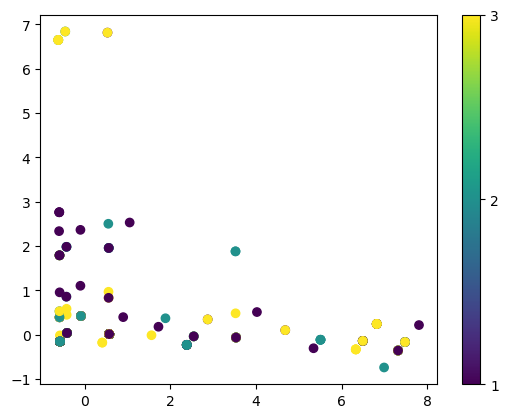

In [6]:
plot_ftrs(X, y, dimensions=2)

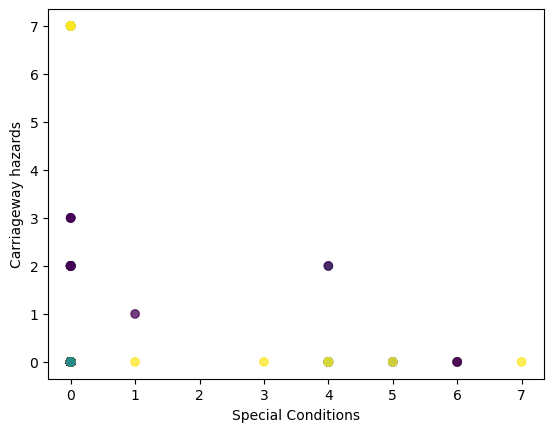

In [7]:
plt.scatter(accident_data[:, 2], accident_data[:, 3], c=y, cmap="viridis", alpha=0.75)
plt.xlabel("Special Conditions")
plt.ylabel("Carriageway hazards")
plt.show()

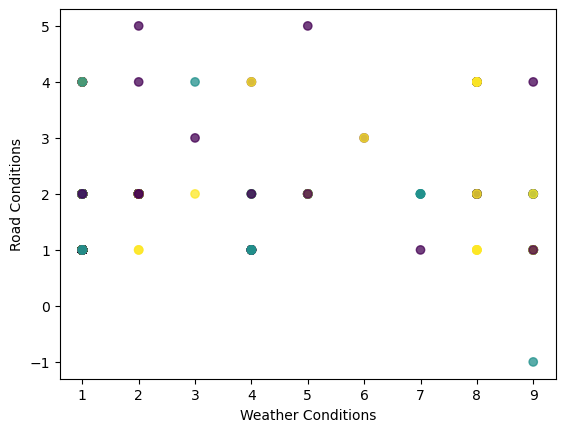

In [8]:
plt.scatter(accident_data[:, 0], accident_data[:, 1], c=y, cmap="viridis", alpha=0.75)
plt.xlabel("Weather Conditions")
plt.ylabel("Road Conditions")
plt.show()

In [9]:
params = {
    "kernel": ["linear", "rbf"],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "gamma": [0.001, 0.01, 0.1, 1, 10],
}
results = custom_cv(SVC(), X, y, params=params, verbose=True)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Total Cross Validation fit time: 0.114 minutes


In [10]:
print(f"Best SVM accuracy = {results['best_accuracy']:.3f}%")
print("Best SVM parameters = ", results['best_params'])
print(f"Best SVM score = {results['best_score']:.3f}%")

Best SVM accuracy = 81.715%
Best SVM parameters =  {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
Best SVM score = 0.343%


In [11]:
# Using Random Forests for a classifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
def run_random_forest_classifier(X, y):
    
    rfc_params = {
        "n_estimators": [10, 100, 1000],
    }
    rfc_results = custom_cv(RandomForestClassifier(), X, y, params = rfc_params, verbose = True);
    
    print(f"Best RFC accuracy = {rfc_results['best_accuracy']:.3f}%")
    print("Best RFC parameters = ", rfc_results['best_params'])
    print(f"Best RFC score = {rfc_results['best_score']:.3f}%")
    
    return rfc_results['best_accuracy']

In [13]:
print("Accuracy of Random Forest Classification: ", run_random_forest_classifier(X, y))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Total Cross Validation fit time: 0.091 minutes
Best RFC accuracy = 89.836%
Best RFC parameters =  {'n_estimators': 10}
Best RFC score = 0.331%
Accuracy of Random Forest Classification:  89.836


In [14]:
from sklearn.neighbors import KNeighborsClassifier
def run_knn_classifier(X, y):
    knn_params = {
        "n_neighbors": [1, 2, 4, 8, 10, 20, 40, 80],
    }
    knn_results = custom_cv(KNeighborsClassifier(), X, y, params = knn_params, verbose = True)
    
    print(f"Best KNN accuracy = {knn_results['best_accuracy']:.3f}%")
    print("Best KNN parameters = ", knn_results['best_params'])
    print(f"Best KNN score = {knn_results['best_score']:.3f}%")
    
    return knn_results['best_accuracy']

In [15]:
print("Accuracy of K Nearest Neighbors Classification: ", run_knn_classifier(X, y))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Total Cross Validation fit time: 0.003 minutes
Best KNN accuracy = 90.464%
Best KNN parameters =  {'n_neighbors': 80}
Best KNN score = 0.346%
Accuracy of K Nearest Neighbors Classification:  90.464
